In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from wordcloud import WordCloud
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,Callback,EarlyStopping

%matplotlib inline
 #it will comprees the graph  in a cell 

## Reading the animelist.csv

In [2]:
import os
Input_Dir = os.path.join("..","artifacts","raw")

In [3]:
rating_df = pd.read_csv(Input_Dir+"/animelist.csv",low_memory = True,usecols=["user_id","anime_id","rating"])
rating_df.head(2)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7


## Data Processing

In [4]:
n_rating = rating_df['user_id'].value_counts()

In [5]:
n_rating

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [6]:
rating_df1 = rating_df[rating_df["user_id"].isin(n_rating[n_rating>=400].index)]
len(rating_df1)

3246641

## here what we  doing we extacting ,that user_id which is experience in Anime and who giving lot of rationg so it will help to build good recommendation model 

In [7]:
min_rating = min(rating_df1['rating']) #0
max_rating = max(rating_df1['rating']) #10
average_rating = np.mean(rating_df1['rating']) #4.122

## min-max scaling of the rating 

Q:- why we doing min- max?
Ans:- Neural networks perform better when inputs are within a small range

In [8]:
rating_df1['rating'] = rating_df1['rating'].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

C:\Users\vardm\AppData\Local\Temp\ipykernel_27788\847279350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df1['rating'] = rating_df1['rating'].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)


In [9]:
rating_df1.duplicated().sum()
rating_df1.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [10]:
user_ids = rating_df1['user_id'].unique().tolist()
user2user_encoded  = {x:i for i,x in enumerate(user_ids)}
user2user_decoded  = {i:x for i,x in enumerate(user_ids)}
rating_df1["user"] = rating_df1['user_id'].map(user2user_encoded)
rating_df1

C:\Users\vardm\AppData\Local\Temp\ipykernel_27788\244268191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df1["user"] = rating_df1['user_id'].map(user2user_encoded)


,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
...,...,...,...,...
4999916,16507,8985,0.0,4202
4999917,16507,5454,0.0,4202
4999918,16507,15911,0.0,4202
4999919,16507,878,0.0,4202


In [11]:
# No. of experience users
n_users = len(user2user_encoded)

#why we doing thsi encoding and decoding ?
#Ans:-These IDs are random and large numbers, which ML models can’t use directly. We convert these random IDs into small, sequential numbers (starting from 0).This makes computations faster and memory-efficient.


In [12]:
anime_ids = rating_df1['anime_id'].unique().tolist()
anime2anime_encoded  = {x:i for i,x in enumerate(anime_ids)}
anime2anime_decoded  = {i:x for i,x in enumerate(anime_ids)}
rating_df1["anime"] = rating_df1['anime_id'].map(anime2anime_encoded)
rating_df1

#Label Encoding does the same thing as your user2user_encoded and user2user_decoded mappings.

C:\Users\vardm\AppData\Local\Temp\ipykernel_27788\2751474549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df1["anime"] = rating_df1['anime_id'].map(anime2anime_encoded)


,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
4999916,16507,8985,0.0,4202,2533
4999917,16507,5454,0.0,4202,817
4999918,16507,15911,0.0,4202,2455
4999919,16507,878,0.0,4202,2154


In [13]:
n_anime  = len(anime2anime_encoded)

In [14]:
n_anime

17149

# now we will shuffle the data to prevent from dataleakage

In [15]:
rating_df1 = rating_df1.sample(frac = 1,random_state = 43).reset_index(drop = True)
rating_df1.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [69]:
X = rating_df1[["user","anime"]].values
y = rating_df1["rating"]



In [ ]:
test_size = 1000
train_size = rating_df1.shape[0] - test_size
train_size

3245641

In [18]:
X_train, X_test, y_train, y_test = (
    X[:train_size],
    X[train_size:],
    y[:train_size],
    y[train_size:]
)

In [19]:
len(X_test)
X_train

array([[ 120, 1377],
       [1195, 1216],
       [1591, 1239],
       ...,
       [ 368,  861],
       [2198, 2402],
       [  81, 1262]])

We split X_train because our neural network needs two separate inputs: one for users, one for animes.
✅ This allows the model to learn separate embeddings for users and animes, improving recommendations.
✅ If we don’t split, the model won’t work correctly.

In [20]:
X_train_array = [X_train[:,0],X_train[:,1]]
X_train_array

[array([ 120, 1195, 1591, ...,  368, 2198,   81]),
 array([1377, 1216, 1239, ...,  861, 2402, 1262])]

In [21]:
X_test_array = [X_test[:,0],X_test[:,1]]
type(X_test_array)

list

## Model Architecture

In [22]:
def RecommenderNet():
    embedding_size = 128 #means each user and anime (item) will be represented as a 128-dimensional vector.

    user = Input(name = 'user',shape = [1])
    user_embedding = Embedding(name = 'user_embedding',input_dim=n_users,output_dim = embedding_size)(user)
    anime = Input(name = 'anime',shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',input_dim = n_anime,output_dim = embedding_size)(anime)
    '''user_id = 3 → [0.1, -0.3, ..., 0.7] (128 values)
    anime_id = 5 → [0.5, -0.1, ..., -0.4] (128 values)'''


    x = Dot(name = "dot_product",normalize = True,axes = 2)([user_embedding,anime_embedding])
    # it give the similarity between 
    
    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs = [user,anime],outputs = x)
    model.compile(loss = 'binary_crossentropy',metrics = ['mae','mse'],optimizer = 'Adam')
    return model




In [23]:
model = RecommenderNet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [24]:
# This code is get from stack over flow

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,Callback,EarlyStopping

lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose = 0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True,monitor = 'val_loss',mode = 'min',save_best_only = True)

early_stopping = EarlyStopping(patience = 3,monitor = 'val_loss',mode = 'min',restore_best_weights = True)

In [26]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [27]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array,y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - loss: 0.7999 - mae: 0.3820 - mse: 0.1970 - val_loss: 0.7188 - val_mae: 0.3600 - val_mse: 0.1670 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - loss: 0.7677 - mae: 0.3691 - mse: 0.1841 - val_loss: 0.7485 - val_mae: 0.3609 - val_mse: 0.1771 - learning_rate: 9.0000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.7281 - mae: 0.3514 - mse: 0.1676 - val_loss: 0.7127 - val_mae: 0.3422 - val_mse: 0.1616 - learning_rate: 8.0000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.6713 - mae: 0.3231 - mse: 0.1434 - val_loss: 0.6598 - val_mae: 0.3147 - val_mse: 0.1388 - learning_rate: 7.0000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - loss: 0.6228 - mae: 0.2968 - mse: 0.1222 - val_loss: 0.6259 - val_mae: 0.2971 - val_mse: 0.1241 - learning_rate: 6.0000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - loss: 0.5969 - mae: 0.2815 - mse: 0.1107 - v

In [28]:
model.load_weights(checkpoint_filepath)

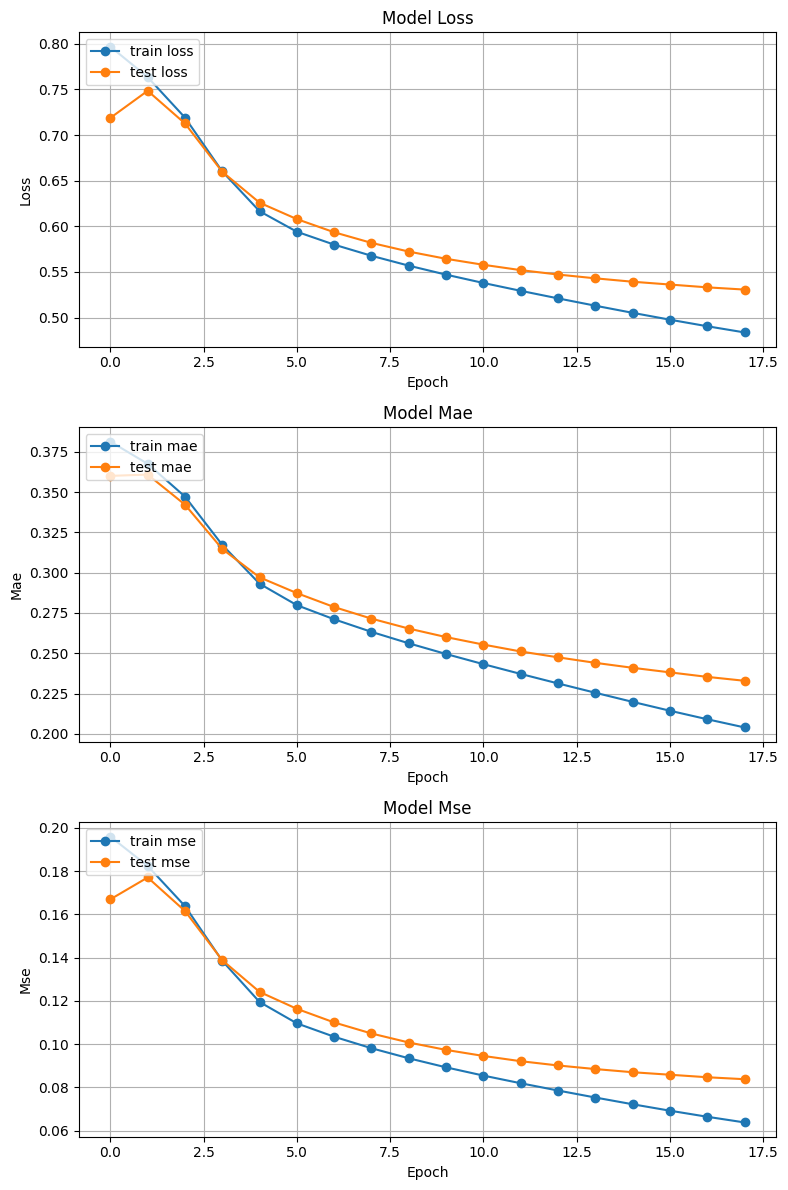

In [29]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [30]:
def extract_weight(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis = 1).reshape((-1,1))
    return weights

In [31]:
anime_weights = extract_weight("anime_embedding",model)


In [32]:
user_weights = extract_weight("user_embedding",model)

## Reading anime.csv

In [33]:
df = pd.read_csv(Input_Dir+"/anime.csv",low_memory=True)
df.shape

(17562, 35)

In [34]:
df = df.replace("Unknown",np.nan)

In [35]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [36]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))
df.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun


In [37]:
getAnimeName(67)

'Basilisk'

In [38]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [39]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [40]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [41]:
df.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [42]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [43]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [44]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV 

In [45]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [46]:
synopsis_df = pd.read_csv(Input_Dir+"/anime_with_synopsis.csv",usecols=cols)

In [47]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [48]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [49]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [50]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [51]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [52]:
pd.set_option("max_colwidth",None)

In [53]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists) # sort from least similar to most similar

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       
        
       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
        synopsis = getSynopsis(decoded_id,synopsis_df)
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
            "synopsis":synopsis
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [54]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n= 2
)

,name,similarity,genre,synopsis
1,Code Geass:Lelouch of the Rebellion R2,0.706358,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
0,Fullmetal Alchemist:Brotherhood,0.698140,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."


### USER BASED RECOMMENDATION

In [55]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [56]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,12786,0.438987
8,12308,0.406958
7,5790,0.382857
6,11628,0.381106
5,14226,0.376556
4,10523,0.353745
3,10851,0.351804
2,14348,0.349458
1,1107,0.346004
0,15301,0.344842


In [57]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [58]:
from collections import defaultdict

In [59]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [60]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [61]:
rating_df.head(2)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7


In [62]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




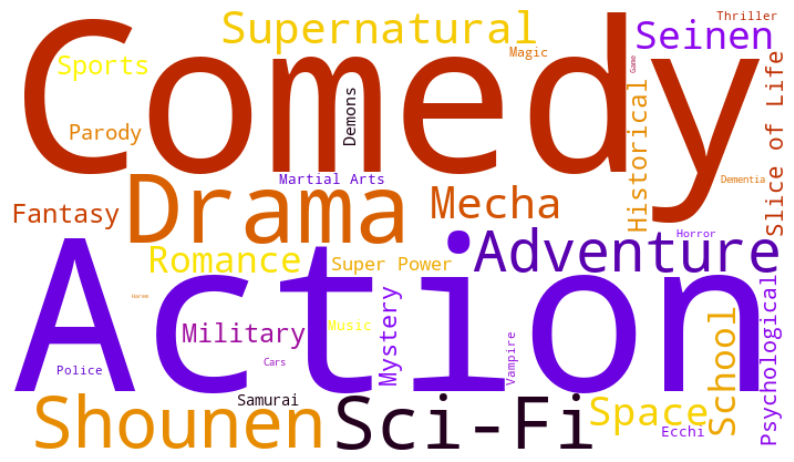

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [63]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [64]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [101]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [102]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [103]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,9,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."


### HYBRID RECOMMENDER SYSTEM

In [115]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [116]:
hybrid_recommendation(11880)

['Steins;Gate', 'Code Geass:Lelouch of the Rebellion R2', '5 Centimeters Per Second', 'Nisekoi:False Love', 'Code Geass:Lelouch of the Rebellion', "KonoSuba:God's Blessing on This Wonderful World!", 'Angel Beats!', 'Spirited Away', 'Little Witch Academia', 'Hyouka']


['Steins;Gate',
 'Code Geass:Lelouch of the Rebellion R2',
 '5 Centimeters Per Second',
 'Nisekoi:False Love',
 'Code Geass:Lelouch of the Rebellion',
 "KonoSuba:God's Blessing on This Wonderful World!",
 'Angel Beats!',
 'Spirited Away',
 'Little Witch Academia',
 'Hyouka']